*Adjusting the Preprocessing Strategy*

Before diving into the following data, I believe it would be helpful to refine the preprocessing strategy.
So far, I have been separating my predictor variables into either continuous or discrete categories. However, there may be differences within discrete variables that need to be addressed. The reason for this consideration is that I have been one-hot encoding all discrete variables, which is generally fine. However, if I start adding interaction terms, this approach could significantly increase the dimensionality of the data. Since we already have a large number of instances in the training set, a substantial increase in dimensionality would greatly increase the computational time required for each step.

As mentioned in the initial notebook, when our data is in numeric format, values like 2 are interpreted as greater than 1. However, in some cases, there is no mathematical relationship or inherent order between such values. To handle this, we can classify discrete variables as either nominal or ordinal:

Nominal variables are discrete variables with no inherent order between categories.
Ordinal variables have an inherent order or ranking between categories.
Below are examples of each:

**Ordinal Variables**
* general_health: As this value increases, an individual's health worsens, indicating an inherent order.
* Other examples: physical_activity_150, education_level, income_group, smoking_status, physical_health_days, and mental_health_days.

**Nominal Variables**
* sex: This variable represents either male or female. There is no inherent order, making it nominal.
* Other examples: has_health_plan, meets_aerobic_guidelines, muscle_strengthening, high_blood_pressure, high_cholesterol, heart_disease, lifetime_asthma, arthritis, alcohol_consumption, binge_drinking, heavy_drinking, and difficulty_walking.

Since ordinal variables have an inherent order and are already represented by numerical values, there is no need to one-hot encode them. However, nominal variables should be one-hot encoded to ensure they are appropriately represented in the model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing pandas and numpy library
import pandas as pd
import numpy as np

# Loading in data frame
df = pd.read_csv('/content/drive/MyDrive/diabetic/df.csv')



# Deleting unnecessary column and symbolizing all non-diabetic records with 0 instead of 3.
del df['Unnamed: 0']
df['diabetes_status'] = df['diabetes_status'].replace(3,0)

# Viewing the non-null count and data type for each feature.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217981 entries, 0 to 217980
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   general_health            217981 non-null  float64
 1   physical_health_days      217981 non-null  float64
 2   mental_health_days        217981 non-null  float64
 3   has_health_plan           217981 non-null  float64
 4   meets_aerobic_guidelines  217981 non-null  float64
 5   physical_activity_150min  217981 non-null  float64
 6   muscle_strengthening      217981 non-null  float64
 7   high_blood_pressure       217981 non-null  float64
 8   high_cholesterol          217981 non-null  float64
 9   heart_disease             217981 non-null  float64
 10  lifetime_asthma           217981 non-null  float64
 11  arthritis                 217981 non-null  float64
 12  sex                       217981 non-null  float64
 13  age                       217981 non-null  f

In [3]:
# Changing the data type for each feature to float32 from float64 to reduce memory needed to store data.
for i in df.columns:
  df[i] = df[i].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217981 entries, 0 to 217980
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   general_health            217981 non-null  float32
 1   physical_health_days      217981 non-null  float32
 2   mental_health_days        217981 non-null  float32
 3   has_health_plan           217981 non-null  float32
 4   meets_aerobic_guidelines  217981 non-null  float32
 5   physical_activity_150min  217981 non-null  float32
 6   muscle_strengthening      217981 non-null  float32
 7   high_blood_pressure       217981 non-null  float32
 8   high_cholesterol          217981 non-null  float32
 9   heart_disease             217981 non-null  float32
 10  lifetime_asthma           217981 non-null  float32
 11  arthritis                 217981 non-null  float32
 12  sex                       217981 non-null  float32
 13  age                       217981 non-null  f

In [4]:
# Isolating target variable.
df_target = df['diabetes_status']
del df['diabetes_status']

# Importing functions to split up and transform our data.
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Creating lists to contain the continuous, ordinal, and nominal variable names
continuous = ['age','height_inches','bmi']

ordinal = ['general_health', 'physical_health_days', 'mental_health_days', 'physical_activity_150min',
           'education_level', 'income_group', 'smoking_status']

nominal = ['has_health_plan', 'meets_aerobic_guidelines', 'muscle_strengthening',
           'high_blood_pressure', 'high_cholesterol', 'heart_disease',
           'lifetime_asthma', 'arthritis', 'sex',
           'alcohol_consumption', 'binge_drinking', 'heavy_drinking',
           'difficulty_walking']

# Splitting up predictor and target variable into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.30, random_state=22, stratify=df_target)
# Utilizing stratify parameters helps ensure that the percentage or diabetic and non-diabetic individuals are around the same in the training and tests sets.

# Creating pipeline to logarithmically transform and scale all continuous variables.
continuous_pipeline = Pipeline([
    ('log', FunctionTransformer(func=np.log1p)),
    ('scaler', StandardScaler()),
    ])

# Creating pipeline to scale each ordinal variable.
ordinal_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

# Creating pipeline to one-hot encode all nominal variables while dropping the first and then scale each variable.
nominal_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse_output=False, drop='first')),
    ('scaler', StandardScaler()),
])

# Creating a column transform to send all continuous to the continuous_pipeline, all ordinal variables to the ordinal_pipeline, and all nominal variables to the nominal_pipeline.
column_transformer = ColumnTransformer([
    ('cont', continuous_pipeline, continuous),
    ('ord', ordinal_pipeline, ordinal),
    ('nom', nominal_pipeline, nominal),
])


# Fitting column transform with training data and then transforming training data using the fitted column transformer.
X_train1 = column_transformer.fit_transform(X_train)
# Transforming testing data using the fitted column transform.
X_test1 = column_transformer.transform(X_test)

nominal_columns = column_transformer.named_transformers_['nom']['one_hot'].get_feature_names_out(nominal).tolist()

correct_columns = continuous + ordinal + nominal_columns

# Creating data frames based on X_train1 and X_test1 for feature importance analysis later one.
X_train1 = pd.DataFrame(X_train1, columns=correct_columns)
X_test1 = pd.DataFrame(X_test1, columns=correct_columns)

In [5]:
# Importing LogisticRegression and f1_score functions.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
# Importing randomized search cv function, stratified fold function for cv.
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [6]:
# Creating a HistGradientBoostingClassifier model, hgbc, with random state set to 42 and class_weight to balanced.
lg = LogisticRegression(random_state=42, class_weight='balanced')

# Fitting hgbc with training data.
lg.fit(X_train1, y_train)

# Calculating f1_score on training data.
pred_target = lg.predict(X_train1)
f1_train = f1_score(y_train, pred_target, pos_label=1.0)
print('f1_score on training data:', np.round(f1_train,2))

# Calculating f1_score on testing data.
pred_target = lg.predict(X_test1)
f1_test = f1_score(y_test, pred_target,pos_label=1.0)
print('f1_score on testing data:', np.round(f1_test,2))

f1_score on training data: 0.46
f1_score on testing data: 0.46


In [7]:
# Creating list to house dictionary of possible parameter values.
param_dist = [{
    'max_iter': [25, 50, 100, 150, 250],
    'class_weight': [{0:1, 1:w} for w in [1, 2, 3, 3.5, 4, 5.69]]
}]

# Creating initial HistGradientBoostingClassifier model.
lg = LogisticRegression(random_state=42)
# Creating initial RandomizedSearchCV function.


rand_search = RandomizedSearchCV(lg, param_distributions=param_dist,
                                scoring= make_scorer(f1_score, pos_label=1.0),
                                cv=StratifiedKFold(n_splits=10),
                                verbose=1, n_iter=20, random_state=22)
# Fitting rand_search with training data.
rand_search.fit(X_train1, y_train)

# Printing the best parameters from the best estimator from rand_search.
print(rand_search.best_params_)

best_estimator = rand_search.best_estimator_
# Calculating f1_score on training data.
pred_target = best_estimator.predict(X_train1)
f1_train = f1_score(y_train, pred_target, pos_label=1.0)
print('f1_score on training data:', np.round(f1_train,2))

# Calculating f1_score on testing data.
pred_target = best_estimator.predict(X_test1)
f1_test = f1_score(y_test, pred_target,pos_label=1.0)
print('f1_score on testing data:', np.round(f1_test,2))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'max_iter': 250, 'class_weight': {0: 1, 1: 3.5}}
f1_score on training data: 0.47
f1_score on testing data: 0.48


In [8]:
# Fitting the column transformer with the whole dataset, and then transforming the whole dataset.
pred_df = column_transformer.fit_transform(df)

# Getting out the column names for the nominal features.
nominal_columns = column_transformer.named_transformers_['nom']['one_hot'].get_feature_names_out(nominal).tolist()

# Creating a list of all the column features
correct_columns = continuous + ordinal + nominal_columns

# Creating new dataframe with correct column names.
pred_df = pd.DataFrame(pred_df, columns=correct_columns)

In [9]:
# Creating new LogisticRegression model based on best parameters from the randomizedsearchcv function.
lg = LogisticRegression(random_state=42, class_weight={0:1, 1:3.5}, max_iter=250)
lg.fit(pred_df, df_target)
pred_target = lg.predict(pred_df)
f1_train = f1_score(df_target, pred_target, pos_label=1.0)
print('f1_score on training data:', np.round(f1_train,2))


f1_score on training data: 0.47


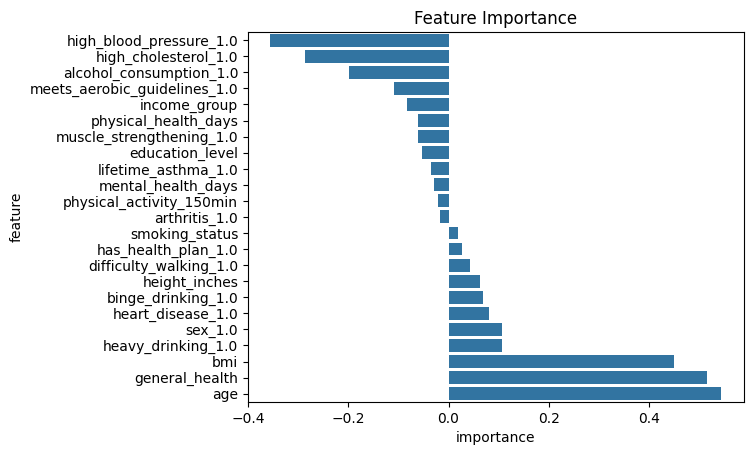

In [10]:
# Loading Data Visualization libraries and functions.
import seaborn as sns
import matplotlib.pyplot as plt

# Creating dataframe to hold the features and their corresponding importance.
scoring = pd.DataFrame()
scoring['feature'] = pred_df.columns
scoring['importance'] = lg.coef_[0]
scoring = scoring.sort_values(by='importance')

# Creating a barplot for the features and their coefficients.
sns.barplot(x='importance', y='feature', data=scoring)
plt.title('Feature Importance')
plt.show()

The larger a feature's coefficient, the more impact it has on the model's predictions. A positive coefficient means that as the feature's value increases, the probability of an individual being diabetic also increases. A negative coefficient means that as the feature's value increases, the probability of being diabetic decreases.

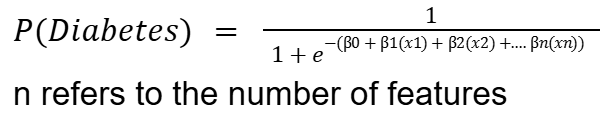





The equation above represents the initial intercept (β0) and the coefficients for each feature (e.g., β1 for the first feature).

Looking at our feature importance graph, age has the largest positive coefficient. This means that, all else being equal, as someone gets older, their probability of having diabetes increases, according to the model.

The feature with the largest negative coefficient is high blood pressure, but interpreting this requires some extra thought. In our data, individuals with high blood pressure were assigned a value of 1, while those without diabetes were mapped as 0. Since the coefficient is around -0.3, having high blood pressure (1) offsets some of that negative effect, making the probability of diabetes slightly higher than if the person didn’t have high blood pressure. Conversely, if an individual does not have high blood pressure (0), the model predicts a lower probability of diabetes—assuming all other factors remain constant.

That being said, the features with the largest positive coefficients are age, general health, and BMI.

The features with the largest negative coefficients are high blood pressure, high cholesterol, and whether the individual has consumed at least one alcoholic drink in the past 30 days.

In [11]:
# Loading in joblib
import joblib

In [12]:
# Saving my lg model and column_transformer
joblib.dump(lg, 'lg.joblib.diab')
joblib.dump(column_transformer, 'column_transformer.joblib.diab')

['column_transformer.joblib.diab']